Epoch [1/1], start
Epoch [1/1], Loss: 0.0376
Accuracy: 99.56%


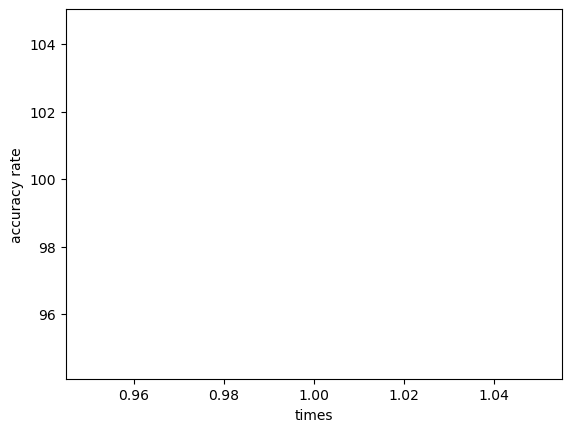

2023-11-27 03:25:17,accuracy_rate=[99.56054688]


RuntimeError: File /Users/zhangying/fruit_reg.pth cannot be opened.

In [4]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import datetime
import numpy as np

from torchvision.datasets import ImageFolder
from torchvision import transforms

from torchvision.models import resnet50

from sklearn.model_selection import train_test_split

# 图像变换
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                     mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]
                                ), ])
# 加载数据集
dataset = ImageFolder('/Users/zhangying/iCloud Drive (Archive) - 2/Desktop/Andrea/Academic 学术/建模资料/亚太地区A题解题/Attachment 2', transform=transform)

# 划分训练集与测试集
train_dataset, valid_dataset = train_test_split(dataset, test_size=0.2, random_state=0)

batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

restnet_pretrained_path = '/Users/zhangying/resnet50-0676ba61.pth'
checkpoint_path = '/Users/zhangying/fruit_reg.pth'
checkpoint_resume = False

if __name__ == "__main__":
    # 加载预训练模型
    model = resnet50()
    model.load_state_dict(torch.load(restnet_pretrained_path))

    # 替换最后一层全连接层,构建新的网络
    num_classes = len(dataset.classes)
    in_features = model.fc.in_features
    model.fc = torch.nn.Linear(in_features, num_classes)

    # 模型训练
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    num_epochs = 1

    accuracy_rate = []
    for epoch in range(num_epochs):

        print('Epoch [{}/{}], start'.format(epoch + 1, num_epochs))

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item()))

        # 模型验证
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total * 100
        accuracy_rate.append(accuracy)
        print('Accuracy: {:.2f}%'.format(accuracy))

    accuracy_rate = np.array(accuracy_rate)
    times = np.linspace(1, num_epochs, num_epochs)
    plt.xlabel('times')
    plt.ylabel('accuracy rate')
    plt.plot(times, accuracy_rate)
    plt.show()

    print(f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')},accuracy_rate={accuracy_rate}")
    # torch.save(model.state_dict(), checkpoint_path)
    torch.save(model,checkpoint_path)


This is the forecast Model

In [ ]:
import torch
from torchvision import models, transforms
from torchvision.models import resnet50
from PIL import Image
import os
import re
import matplotlib.pyplot as plt

def extract_numbers_in_brackets(input_string):
    # 使用正则表达式匹配括号内的数字
    pattern = r'\((\d+)\)'
    matches = re.findall(pattern, input_string)

    # 返回匹配到的数字列表
    return [int(match) for match in matches][0]


# 加载预训练的ResNet-50模型
model = resnet50()
model_path = './checkpoint/fruit_reg.pth'
# model.load_state_dict(torch.load(model_path))
model = torch.load(model_path)
# print(net)
model.eval()  # 将模型设置为评估模式，这是因为在推理阶段不需要梯度

# 定义数据转换
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet-50的输入尺寸为224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 获取指定路径下的所有文件和文件夹
directory = '/Users/wuguobin/Documents/model/Attachment/Attachment 3/'
files = os.listdir(directory)

appleID = []
# 遍历文件和文件夹
for file in files:
    # 获取文件或文件夹的完整路径
    image_path = os.path.join(directory, file)

    # 加载图像并进行预测
    # image_path = '/Users/wuguobin/Documents/model/Attachment/Attachment 3/Fruit (75).jpg'
    image = Image.open(image_path)
    input_tensor = transform(image)
    input_batch = input_tensor.unsqueeze(0)  # 添加一个维度表示批次大小

    # 使用模型进行预测
    with torch.no_grad():
        output = model(input_batch)

    # 加载类标签文件
    # with open('imagenet_classes.txt', 'r') as f:
    #     classes = [line.strip() for line in f.readlines()]

    # 获取预测结果
    _, predicted_idx = torch.max(output, 1)
    # print(predicted_idx)
    # predicted_label = classes[predicted_idx.item()]
    # print(f'Predicted label: {predicted_label}')

    # 如果是苹果，记录苹果ID
    if predicted_idx==0:
        num = extract_numbers_in_brackets(image_path)
        print(num)
        appleID.append(num)

print(len(appleID))

# 绘制直方图
plt.hist(appleID, bins=50, color='skyblue', edgecolor='black')  # bins为柱子数量
plt.xlabel('ID numbers of all apple images')
plt.ylabel('freq')
plt.title('distribution histogram')
plt.show()